# 🐍🤖 Обучение с подкрплением. Разработка агента, способного самостоятельно принимать решение о переключении светофоров и предлагать сотруднику действия:

In [ ]:
import numpy as np
import random

class TrafficSituation:
    def __init__(self):
        self.traffic_flow = random.randint(50, 150)  # Количество машин в минуту
        self.speed = random.uniform(5, 30)  # Скорость потока в км/ч

    def get_situation(self):
        return self.traffic_flow, self.speed

class TrafficLightEnv:
    def __init__(self):
        self.state = 0  # Начальное состояние (0 - красный, 1 - зеленый)
        self.time = 0   # Время, прошедшее с последнего изменения состояния
        self.traffic_situation = TrafficSituation()  # Изначально создаем дорожную ситуацию

    def reset(self):
        self.state = 0  # Сброс состояния (красный)
        self.time = 0
        self.traffic_situation = TrafficSituation()  # Генерируем новую дорожную ситуацию
        return self.state

    def step(self, action):
        # Обновляем дорожную ситуацию на каждом шаге
        self.traffic_situation = TrafficSituation()
        traffic_flow, speed = self.traffic_situation.get_situation()

        # Действия: 0 - держать текущее состояние, 1 - переключить на зеленый, 2 - переключить на красный
        if action == 1 and self.state == 0:  # Переключение на зеленый
            self.state = 1
            reward = 1 + (traffic_flow / 100) - (speed / 30)  # Награда зависит от ситуации
            action_description = "Агент переключил на зелёный"
            correctness = "верное"
        elif action == 2 and self.state == 1:  # Переключение на красный
            self.state = 0
            reward = 1 + (traffic_flow / 100) - (speed / 30)  # Награда зависит от ситуации
            action_description = "Агент переключил на красный"
            correctness = "верное"
        elif action == 0:  # Держать текущее состояние
            reward = 0.5  # Награда за удержание состояния (можно настроить)
            action_description = "Агент держит текущее состояние"
            correctness = "верное"
        else:
            reward = -1  # Негативная награда за неправильное действие
            action_description = "Агент попытался переключить, но действие неверное"
            correctness = "неверное"

        self.time += 1
        done = self.time >= 10  # Завершение эпизода через 10 шагов

        return self.state, reward, done, action_description, correctness, traffic_flow, speed

class QLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.99):
        self.q_table = np.zeros((2, len(actions)))  # 2 состояния (красный и зеленый)
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.actions = actions

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(self.actions)  # Исследование
        return np.argmax(self.q_table[state])  # Эксплуатация

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_delta = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_delta

def play_game(agent, env):
    print("Добро пожаловать в игру 'Светофор'!")
    print("Ваши действия:")
    print("1 - Переключить на зелёный")
    print("2 - Переключить на красный")
    print("0 - Держать текущее состояние")
    print("Введите 'q' для выхода из игры.")

    state = env.reset()
    done = False
    while not done:
        traffic_flow, speed = env.traffic_situation.get_situation()  # Получаем ситуацию перед каждым действием
        print(f"\nТекущее состояние светофора: {'Зеленый' if state == 1 else 'Красный'}")
        print(f"Текущая дорожная ситуация: {traffic_flow} машин в минуту, скорость потока: {speed:.2f} км/ч")
        action = input("Выберите действие (0, 1, 2): ")

        if action == 'q':
            print("Вы вышли из игры.")
            break

        action = int(action)
        next_state, reward, done, action_description, correctness, traffic_flow, speed = env.step(action)

        # Обучение агента
        agent.learn(state, action, reward, next_state)

        # Отладочные сообщения
        print(f"Действие: {action} - {action_description} ({correctness}), Награда: {reward:.2f}, Следующее состояние: {'Зеленый' if next_state == 1 else 'Красный'}")

        state = next_state

    print("Эпизод завершен!")

# Основная часть
env = TrafficLightEnv()
agent = QLearningAgent(actions=[0, 1, 2])  # Действия: 0 - держать, 1 - переключить на зеленый, 2 - переключить на красный

# Обучение агента
num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    done = False

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done, action_description, correctness, traffic_flow, speed = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state

    agent.exploration_rate *= agent.exploration_decay  # Уменьшение коэффициента исследования

# После обучения запускаем игру
play_game(agent, env)

# После игры можно проверить Q-таблицу
print("Q-таблица:")
print(agent.q_table)

Добро пожаловать в игру 'Светофор'!
Ваши действия:
1 - Переключить на зелёный
2 - Переключить на красный
0 - Держать текущее состояние
Введите 'q' для выхода из игры.

Текущее состояние светофора: Красный
Текущая дорожная ситуация: 73 машин в минуту, скорость потока: 9.34 км/ч
Выберите действие (0, 1, 2): 1
Действие: 1 - Агент переключил на зелёный (верное), Награда: 1.82, Следующее состояние: Зеленый

Текущее состояние светофора: Зеленый
Текущая дорожная ситуация: 133 машин в минуту, скорость потока: 15.16 км/ч
Выберите действие (0, 1, 2): 0
Действие: 0 - Агент держит текущее состояние (верное), Награда: 0.50, Следующее состояние: Зеленый

Текущее состояние светофора: Зеленый
Текущая дорожная ситуация: 101 машин в минуту, скорость потока: 13.31 км/ч
Выберите действие (0, 1, 2): 0
Действие: 0 - Агент держит текущее состояние (верное), Награда: 0.50, Следующее состояние: Зеленый

Текущее состояние светофора: Зеленый
Текущая дорожная ситуация: 119 машин в минуту, скорость потока: 9.87 км

# 🤖 Обучение агента на поиск оптимального пути обхода заторов:

Добро пожаловать в симуляцию 'Обход заторов'!


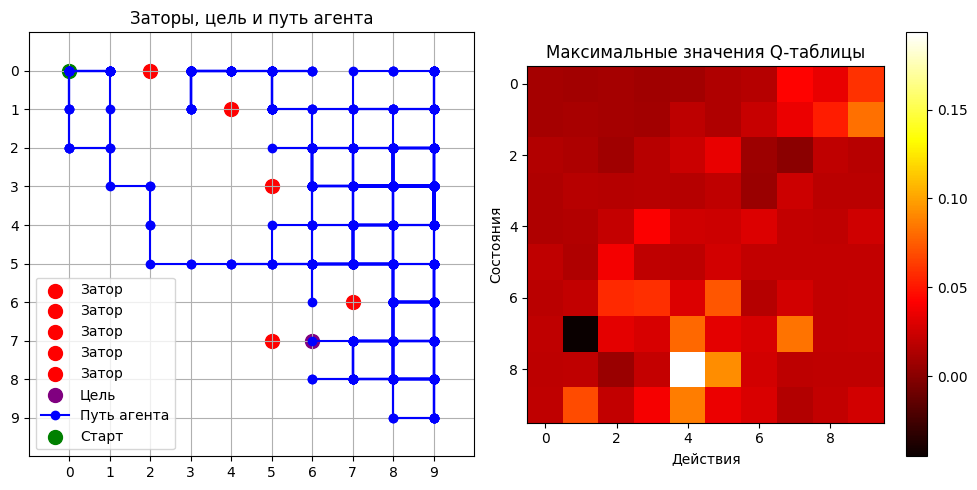

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt

class GridEnvironment:
    def __init__(self, grid_size=10, num_obstacles=5):
        self.grid_size = grid_size
        self.num_obstacles = num_obstacles
        self.reset()

    def reset(self):
        self.agent_position = (0, 0)  # Начальная позиция агента
        self.obstacles = self.generate_obstacles()  # Генерация заторов
        self.target_position = self.generate_target()  # Генерация цели
        return self.agent_position

    def generate_obstacles(self):
        obstacles = set()
        while len(obstacles) < self.num_obstacles:
            obs = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if obs != (0, 0):  # Не ставим затор в начальную позицию агента
                obstacles.add(obs)
        return obstacles

    def generate_target(self):
        while True:
            target = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if target not in self.obstacles and target != (0, 0):
                return target

    def step(self, action):
        # Действия: 0 - вверх, 1 - вниз, 2 - влево, 3 - вправо
        new_position = list(self.agent_position)

        if action == 0:  # Вверх
            new_position[0] = max(0, self.agent_position[0] - 1)
        elif action == 1:  # Вниз
            new_position[0] = min(self.grid_size - 1, self.agent_position[0] + 1)
        elif action == 2:  # Влево
            new_position[1] = max(0, self.agent_position[1] - 1)
        elif action == 3:  # Вправо
            new_position[1] = min(self.grid_size - 1, self.agent_position[1] + 1)

        new_position = tuple(new_position)

        if new_position in self.obstacles:
            reward = -1  # Негативная награда за столкновение с затором
            done = False  # Эпизод продолжается
        else:
            self.agent_position = new_position
            reward = 1 if self.agent_position == self.target_position else 0
            done = self.agent_position == self.target_position  # Эпизод завершается, если агент достиг цели

        return self.agent_position, reward, done

class QLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.99):
        self.q_table = np.zeros((10, 10, len(actions)))  # Состояния: координаты (x, y) и действия
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.actions = actions

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(self.actions)  # Исследование
        return np.argmax(self.q_table[state[0], state[1]])  # Эксплуатация

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state[0], next_state[1]])
        td_target = reward + self.discount_factor * self.q_table[next_state[0], next_state[1], best_next_action]
        td_delta = td_target - self.q_table[state[0], state[1], action]
        self.q_table[state[0], state[1], action] += self.learning_rate * td_delta

def play_game(agent, env):
    print("Добро пожаловать в симуляцию 'Обход заторов'!")
    state = env.reset()
    done = False

    path = [state]  # Список для хранения пути агента

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)
        path.append(next_state)  # Сохраняем путь
        state = next_state

    return path

# Основная часть
env = GridEnvironment()
agent = QLearningAgent(actions=[0, 1, 2, 3])  # Действия: 0 - вверх, 1 - вниз, 2 - влево, 3 - вправо

# Обучение агента
num_episodes = 100
for episode in range(num_episodes):
    state = env.reset()
    done = False

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state

    agent.exploration_rate *= agent.exploration_decay  # Уменьшение коэффициента исследования

# После обучения запускаем игру
path = play_game(agent, env)

# Визуализация
plt.figure(figsize=(10, 5))

# График заторов, цели и пути агента
plt.subplot(1, 2, 1)
plt.title("Заторы, цель и путь агента")
plt.xlim(-1, env.grid_size)
plt.ylim(-1, env.grid_size)
plt.xticks(range(env.grid_size))
plt.yticks(range(env.grid_size))
plt.grid()

# Рисуем заторы
for obs in env.obstacles:
    plt.scatter(obs[1], obs[0], color='red', s=100, label='Затор')

# Рисуем цель
plt.scatter(env.target_position[1], env.target_position[0], color='purple', s=100, label='Цель')

# Рисуем путь агента
path = np.array(path)
plt.plot(path[:, 1], path[:, 0], color='blue', marker='o', label='Путь агента')
plt.scatter(0, 0, color='green', s=100, label='Старт')

plt.legend()
plt.gca().invert_yaxis()  # Инвертируем ось Y для правильного отображения

plt.subplot(1, 2, 2)
plt.title("Q-таблица")
plt.imshow(agent.q_table.max(axis=2), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xlabel('Действия')
plt.ylabel('Состояния')
plt.title('Максимальные значения Q-таблицы')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

class GridEnvironment:
    def __init__(self, grid_size=10, num_obstacles=5):
        self.grid_size = grid_size
        self.num_obstacles = num_obstacles
        self.reset()

    def reset(self):
        self.agent_position = (0, 0)  # Начальная позиция агента
        self.obstacles = self.generate_obstacles()  # Генерация заторов
        self.target_position = self.generate_target()  # Генерация цели
        return self.agent_position

    def generate_obstacles(self):
        obstacles = set()
        while len(obstacles) < self.num_obstacles:
            obs = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if obs != (0, 0):  # Не ставим затор в начальную позицию агента
                obstacles.add(obs)
        return obstacles

    def generate_target(self):
        while True:
            target = (random.randint(0, self.grid_size - 1), random.randint(0, self.grid_size - 1))
            if target not in self.obstacles and target != (0, 0):
                return target

    def step(self, action):
        # Действия: 0 - вверх, 1 - вниз, 2 - влево, 3 - вправо
        new_position = list(self.agent_position)

        if action == 0:  # Вверх
            new_position[0] = max(0, self.agent_position[0] - 1)
        elif action == 1:  # Вниз
            new_position[0] = min(self.grid_size - 1, self.agent_position[0] + 1)
        elif action == 2:  # Влево
            new_position[1] = max(0, self.agent_position[1] - 1)
        elif action == 3:  # Вправо
            new_position[1] = min(self.grid_size - 1, self.agent_position[1] + 1)

        new_position = tuple(new_position)

        if new_position in self.obstacles:
            reward = -1  # Негативная награда за столкновение с затором
            done = False  # Эпизод продолжается
        else:
            self.agent_position = new_position
            reward = 1 if self.agent_position == self.target_position else 0
            done = self.agent_position == self.target_position  # Эпизод завершается, если агент достиг цели

        return self.agent_position, reward, done

class QLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, exploration_decay=0.99):
        self.q_table = np.zeros((10, 10, len(actions)))  # Состояния: координаты (x, y) и действия
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.actions = actions

    def choose_action(self, state):
        if random.uniform(0, 1) < self.exploration_rate:
            return random.choice(self.actions)  # Исследование
        return np.argmax(self.q_table[state[0], state[1]])  # Эксплуатация

    def learn(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state[0], next_state[1]])
        td_target = reward + self.discount_factor * self.q_table[next_state[0], next_state[1], best_next_action]
        td_delta = td_target - self.q_table[state[0], state[1], action]
        self.q_table[state[0], state[1], action] += self.learning_rate * td_delta

def play_game(agent, env):
    print("Добро пожаловать в симуляцию 'Обход заторов'!")
    state = env.reset()
    done = False

    path = [state]  # Список для хранения пути агента

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)
        path.append(next_state)  # Сохраняем путь
        state = next_state

    return path

def find_best_path(agent, start, target):
    best_path = [start]
    current_position = start

    while current_position != target:
        action = np.argmax(agent.q_table[current_position[0], current_position[1]])
        current_position = (max(0, min(current_position[0] + (action == 1) - (action == 0), agent.q_table.shape[0] - 1)),
                            max(0, min(current_position[1] + (action == 3) - (action == 2), agent.q_table.shape[1] - 1)))
        best_path.append(current_position)

    return best_path

# Основная часть
env = GridEnvironment()
agent = QLearningAgent(actions=[0, 1, 2, 3])  # Действия: 0 - вверх, 1 - вниз, 2 - влево, 3 - вправо

# Обучение агента
num_episodes = 100
for episode in range(num_episodes):
    state = env.reset()
    done = False

    while not done:
        action = agent.choose_action(state)
        next_state, reward, done = env.step(action)
        agent.learn(state, action, reward, next_state)
        state = next_state

    agent.exploration_rate *= agent.exploration_decay  # Уменьшение коэффициента исследования

# После обучения запускаем игру
path = play_game(agent, env)

# Находим лучший путь
best_path = find_best_path(agent, (0, 0), env.target_position)

# Визуализация
plt.figure(figsize=(15, 5))

# График заторов, цели и пути агента
plt.subplot(1, 2, 1)
plt.title("Заторы, цель и путь агента")
plt.xlim(-1, env.grid_size)
plt.ylim(-1, env.grid_size)
plt.xticks(range(env.grid_size))
plt.yticks(range(env.grid_size))
plt.grid()

# Рисуем заторы
for obs in env.obstacles:
    plt.scatter(obs[1], obs[0], color='red', s=100, label='Затор')

# Рисуем цель
plt.scatter(env.target_position[1], env.target_position[0], color='purple', s=100, label='Цель')

# Рисуем путь агента
path = np.array(path)
plt.plot(path[:, 1], path[:, 0], color='blue', marker='o', label='Путь агента')
plt.scatter(0, 0, color='green', s=100, label='Старт')

plt.legend()
plt.gca().invert_yaxis()  # Инвертируем ось Y для правильного отображения

# График "самого лучшего пути"
plt.subplot(1, 2, 2)
plt.title("Самый лучший путь")
plt.xlim(-1, env.grid_size)
plt.ylim(-1, env.grid_size)
plt.xticks(range(env.grid_size))
plt.yticks(range(env.grid_size))
plt.grid()

# Рисуем заторы
for obs in env.obstacles:
    plt.scatter(obs[1], obs[0], color='red', s=100, label='Затор')

# Рисуем цель
plt.scatter(env.target_position[1], env.target_position[0], color='purple', s=100, label='Цель')

# Рисуем лучший путь
best_path = np.array(best_path)
plt.plot(best_path[:, 1], best_path[:, 0], color='orange', marker='o', label='Самый лучший путь')
plt.scatter(0, 0, color='green', s=100, label='Старт')

plt.legend()
plt.gca().invert_yaxis()  # Инвертируем ось Y для правильного отображения

plt.tight_layout()
plt.show()

Добро пожаловать в симуляцию 'Обход заторов'!
